In [37]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
import extract as xfn
from scipy import stats 
import IS as isfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

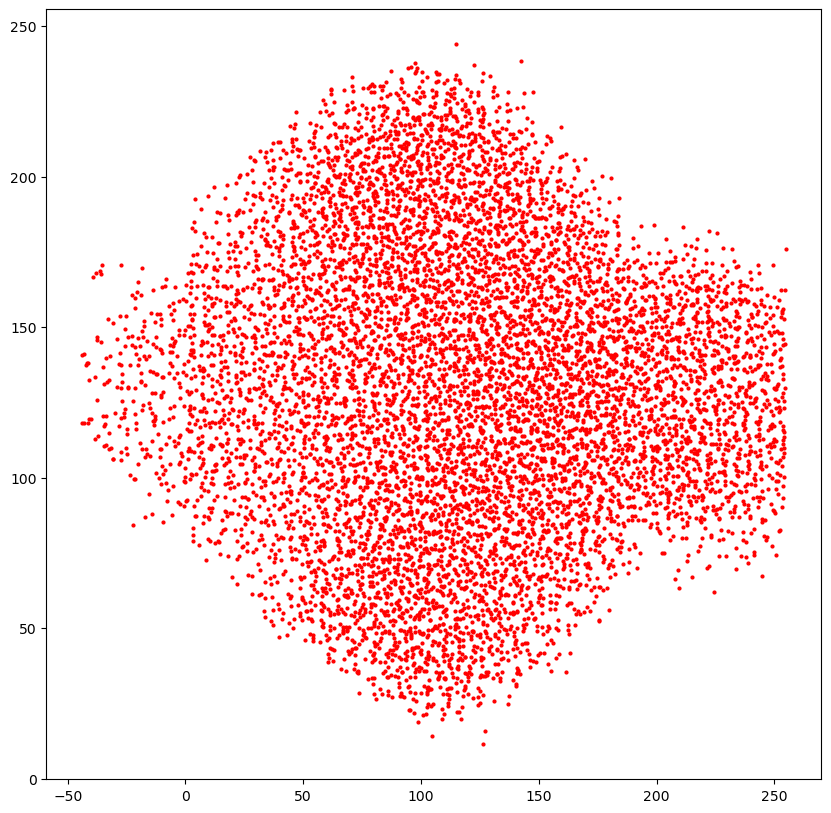

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

In [2]:
# Create lists of trace data
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnraw = sorted(glob.glob('*BLN*_cutrealtrace.npy'))
p5raw = sorted(glob.glob('*PTZ05*_cutrealtrace.npy'))
p20raw = sorted(glob.glob('*PTZ20*_cutrealtrace.npy'))
blnbin = sorted(glob.glob('*BLN*binarised.npy'))
p20bin = sorted(glob.glob('*PTZ20*binarised.npy'))
blnnnb = sorted(glob.glob('*BLN*nnb*'))
p20nnb = sorted(glob.glob('*PTZ20*nnb*'))
blnraw, p20raw
blnbin, p20bin

(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_binarised.npy',
  'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09_0.590binarised.npy'],
 ['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
  'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_PTZ20_run-01_0.590b

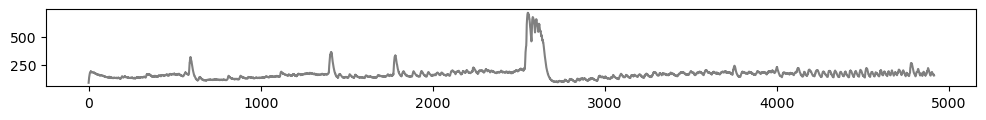

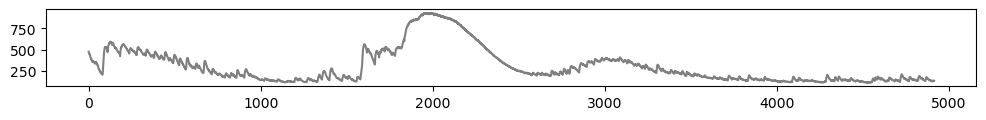

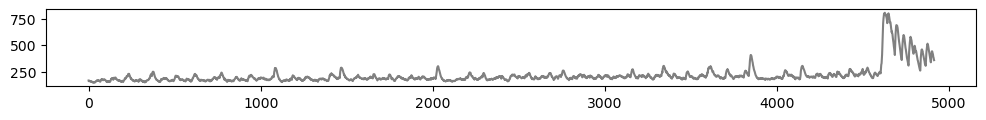

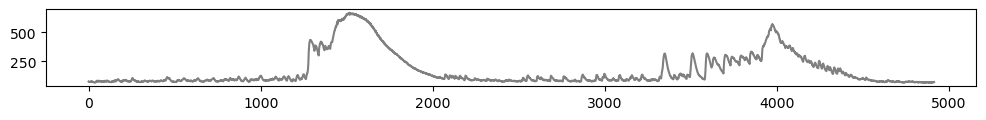

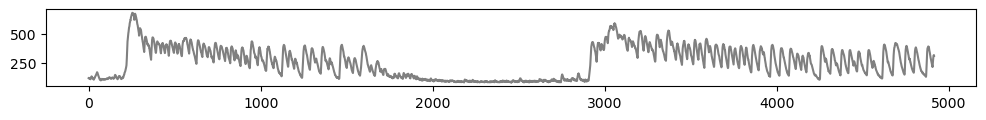

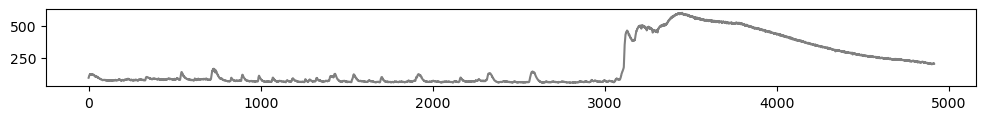

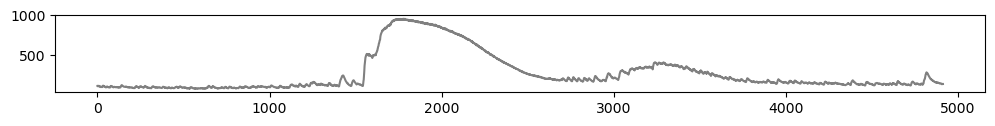

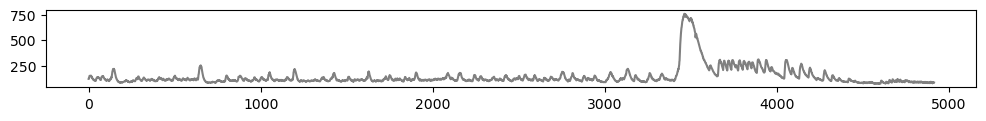

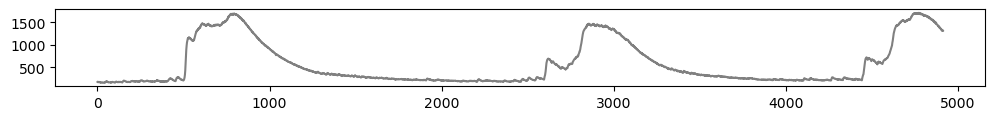

(array(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy',
        'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_PTZ20_run-01_cutrealtrace.npy'],
       dtype='<U66'),
 array(['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
        'PTZ-WILDTYPE-03_2photon_sess-01-BLN-PTZ05-PTZ20_run-01_binarised.npy',
        'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_0.590binarised.npy',
        'PTZ-WILDTYPE-06_2photon_se

In [3]:
#which traces have clear pre-ictal and generalised periods
gen_list, sub_bln_list , gen_blist, sub_bln_blist, gen_nnblist, sub_bln_nnblist, sub_p5_list = [],[],[],[],[],[],[]
for o in range(len(p20raw)):
    p20 = np.load(p20raw[o])
    mean = np.apply_along_axis(np.mean, 0, p20)
    mini, maxi = np.min(mean), np.max(mean)
    if 4*mini < maxi:
        fig, ax = plt.subplots(figsize= (12,1))  
        plt.plot(mean, c='grey')
        gen_list = np.append(gen_list, p20raw[o])
        gen_blist = np.append(gen_blist, p20bin[o])
        gen_nnblist = np.append(gen_nnblist, p20nnb[o])
        sub_bln_list = np.append(sub_bln_list, blnraw[o])
        sub_bln_blist = np.append(sub_bln_blist, blnbin[o])
        sub_bln_nnblist = np.append(sub_bln_nnblist, blnnnb[o])
        sub_p5_list = np.append(sub_p5_list, p5raw[o])
        plt.show()
gen_list, gen_blist, gen_nnblist

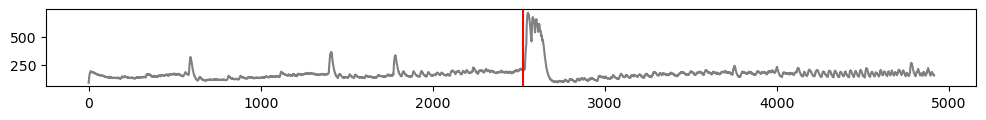

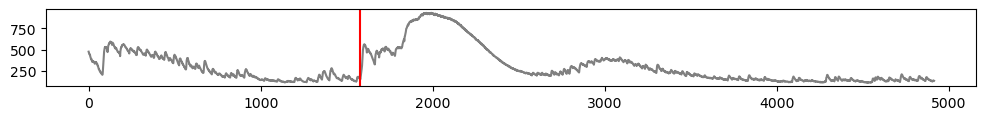

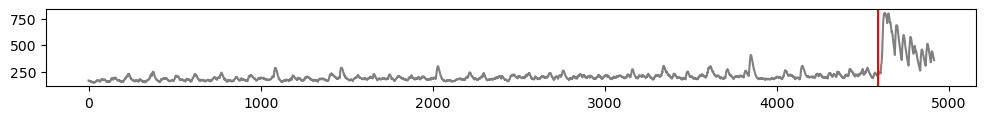

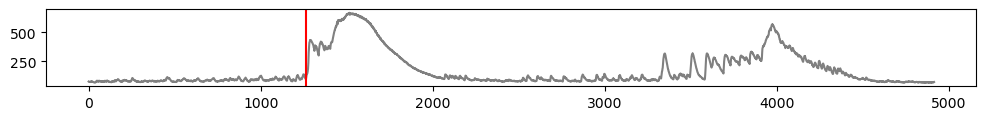

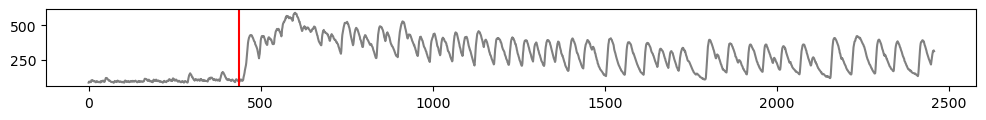

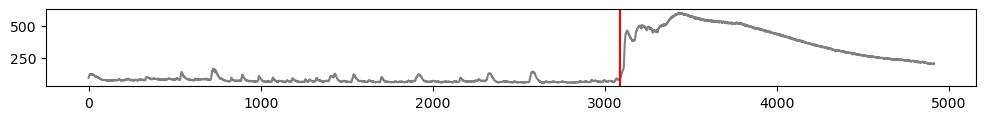

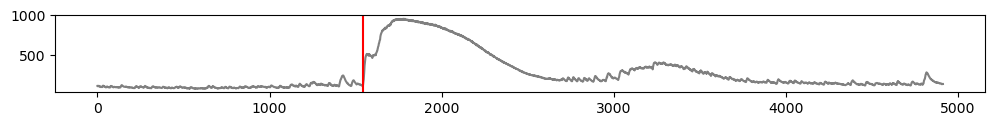

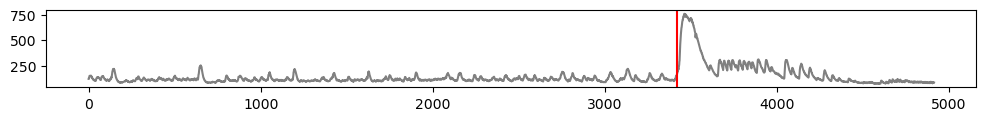

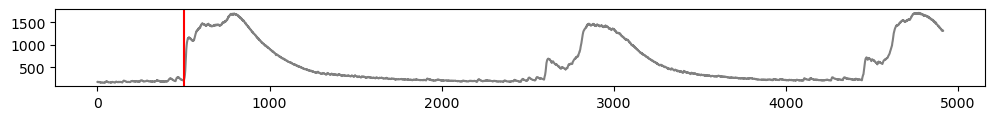

In [4]:
#IDENTIFY GENERALISED EVENT
max_list = list(range(len(gen_list)))
for o in range(len(gen_list)):
    p20 = np.load(gen_list[o])
    mean = np.apply_along_axis(np.mean, 0, p20)
    if o == 4:
        mean = mean[np.int(mean.shape[0]/2):]
    window = adfn.window(30, mean.shape[0])[0]
    diffs = list(range(mean.shape[0] - window))
    for t in range(mean.shape[0]):
        if t == mean.shape[0] - window:
            break
        diff_vec = np.zeros(window)
        for e in range(window):
            diff_vec[e] = mean[t+e] - mean[t] 
        diffs[t] = diff_vec
    
    sums, maxs = list(range(len(diffs))),list(range(len(diffs)))
    for i in range(len(diffs)):
        maxs[i] = np.max(diffs[i])

    fig, ax = plt.subplots(figsize= (12,1))  
    when = np.where(maxs ==  np.max(maxs))[0]
    plt.plot(mean, c = 'grey')
    for x in when: plt.axvline(x=x, c='red')
    max_list[o] = np.where(maxs ==  np.max(maxs))[0]
    plt.show()

In [5]:
#Time series for baseline, preictal, ictal analysis
import random
window = 400
bln_list, bln_blist = list(range(len(gen_list))),list(range(len(gen_list)))
pre_list, pre_blist = list(range(len(gen_list))),list(range(len(gen_list)))
p20_list, p20_blist = list(range(len(gen_list))),list(range(len(gen_list)))

for e in range(len(gen_list)):
    bln_ran = random.randint(0,4914-window)
    bln_list[e] = np.load(sub_bln_list[e])[:,bln_ran:bln_ran+window]
    bln_blist[e] = np.load(sub_bln_blist[e])[:,bln_ran:bln_ran+window]
    if e == 4:
        pre_list[e] = np.load(gen_list[e])[:,np.int(4914/2)+max_list[e][0]-window:np.int(4914/2)+max_list[e][0]]
        pre_blist[e] = np.load(gen_blist[e])[:,np.int(4914/2)+max_list[e][0]-window:np.int(4914/2)+max_list[e][0]]
        p20_list[e] = np.load(gen_list[e])[:,np.int(4914/2)+max_list[e][0]:np.int(4914/2)+max_list[e][0]+window]
        p20_blist[e] = np.load(gen_blist[e])[:,np.int(4914/2)+max_list[e][0]:np.int(4914/2)+max_list[e][0]+window]
    else:
        pre_list[e] = np.load(gen_list[e])[:,max_list[e][0]-window:max_list[e][0]]
        pre_blist[e] = np.load(gen_blist[e])[:,max_list[e][0]-window:max_list[e][0]]
        p20_list[e] = np.load(gen_list[e])[:,max_list[e][0]:max_list[e][0]+window]
        p20_blist[e] = np.load(gen_blist[e])[:,max_list[e][0]:max_list[e][0]+window]

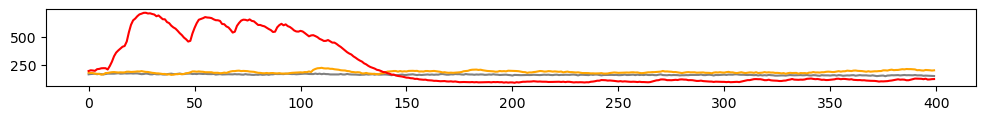

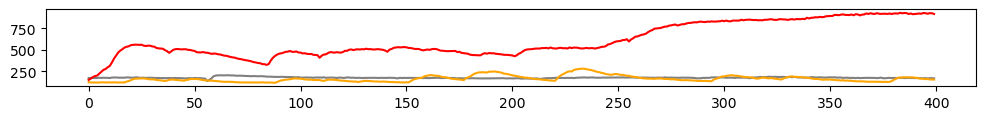

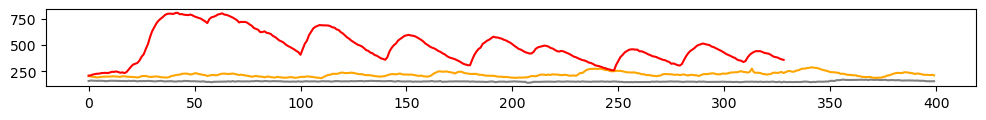

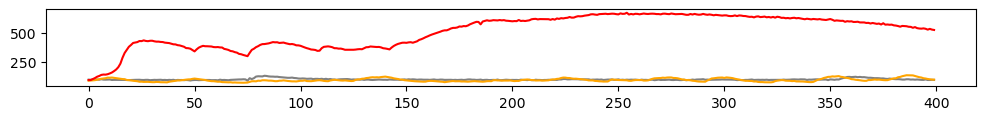

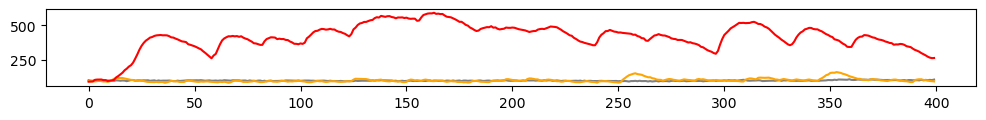

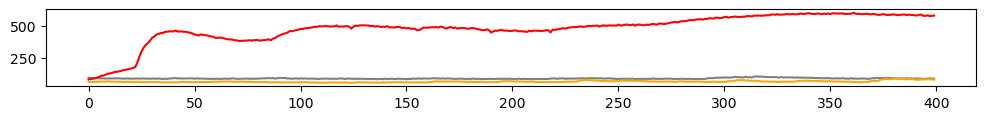

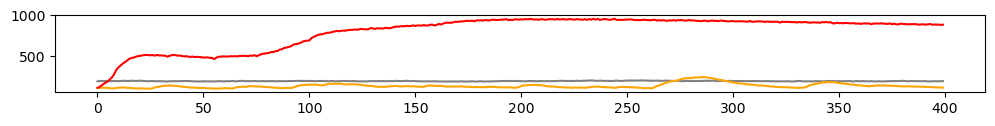

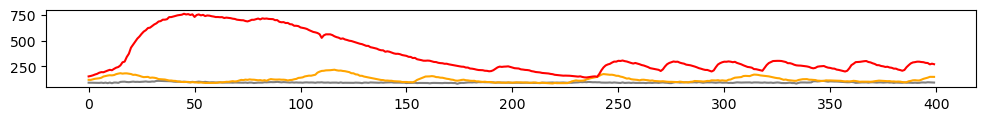

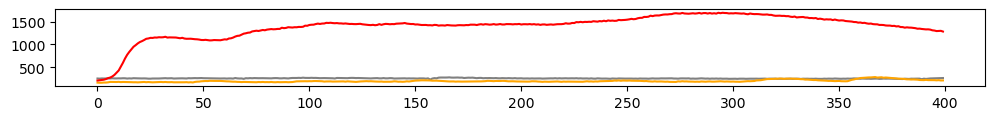

In [10]:
#Check time series
for i in range(len(bln_list)):
    fig, ax = plt.subplots(figsize= (12,1))  
    mean = np.apply_along_axis(np.mean, 0, bln_list[i])
    plt.plot(mean, c='grey')
    mean = np.apply_along_axis(np.mean, 0, pre_list[i])
    plt.plot(mean, c='orange')
    mean = np.apply_along_axis(np.mean, 0, p20_list[i])
    plt.plot(mean, c='red')
    plt.show()

In [30]:
# Create lists of trace data
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
coords = sorted(glob.glob('*02*PTZ20*realcoord*'))
coords

['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_realcoord.npy']

In [44]:
nnb_list = np.linspace(0.25, 0.5, 5)
bcl_list = np.linspace(0.4, 0.7, 5)
nnb_list, bcl_list

(array([0.25  , 0.3125, 0.375 , 0.4375, 0.5   ]),
 array([0.4  , 0.475, 0.55 , 0.625, 0.7  ]))

In [22]:
data = p20_list[0]

Doing row 0 of 8971
Doing row 897 of 8971
Doing row 1794 of 8971
Doing row 2691 of 8971
Doing row 3588 of 8971
Doing row 4485 of 8971
Doing row 5382 of 8971
Doing row 6279 of 8971
Doing row 7176 of 8971
Doing row 8073 of 8971
Doing row 8970 of 8971
doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.25 0.4


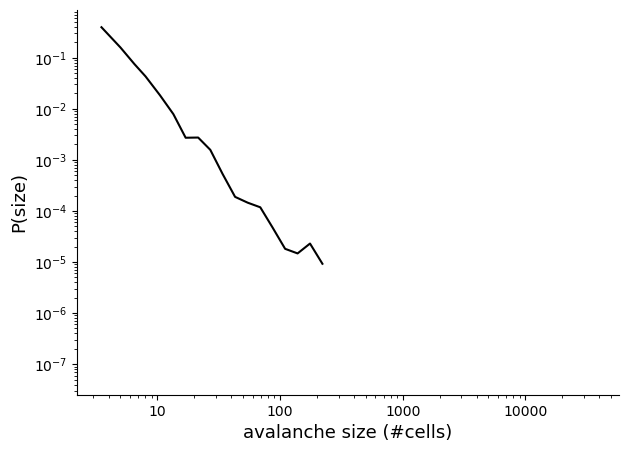

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.25 0.475


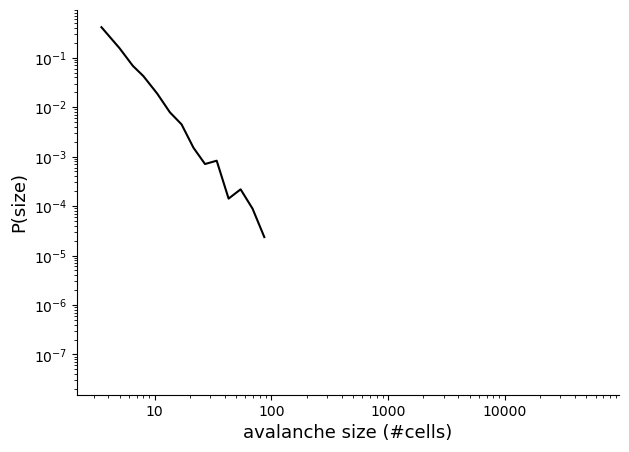

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.25 0.55


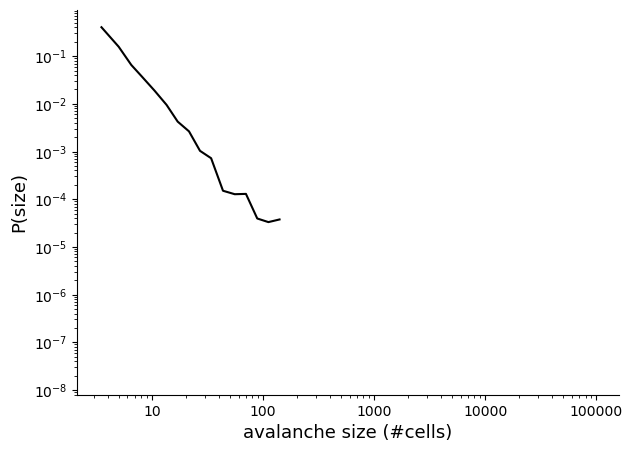

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.25 0.625


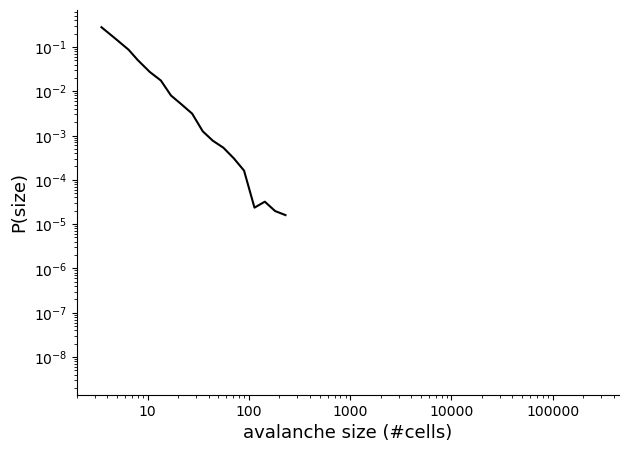

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.25 0.7


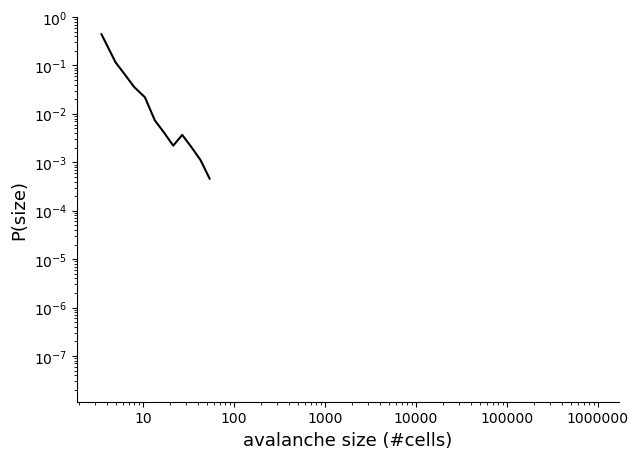

Doing row 0 of 8971
Doing row 897 of 8971
Doing row 1794 of 8971
Doing row 2691 of 8971
Doing row 3588 of 8971
Doing row 4485 of 8971
Doing row 5382 of 8971
Doing row 6279 of 8971
Doing row 7176 of 8971
Doing row 8073 of 8971
Doing row 8970 of 8971
doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.3125 0.4


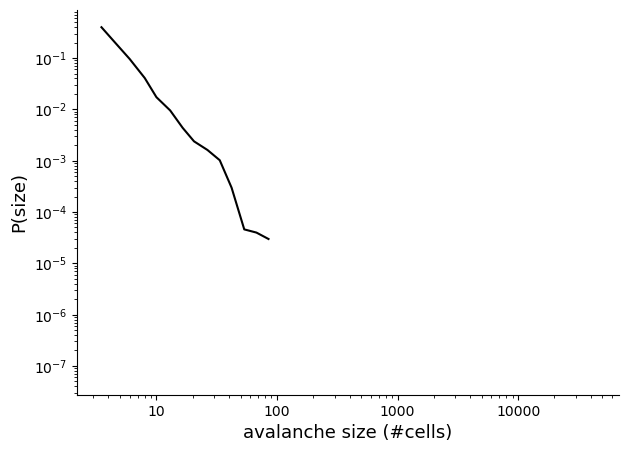

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.3125 0.475


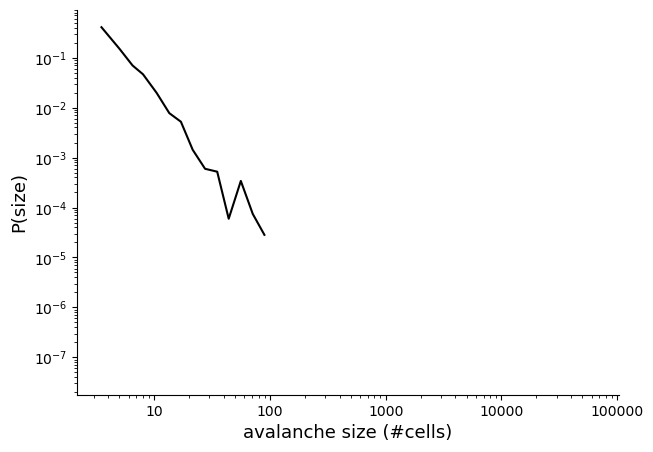

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.3125 0.55


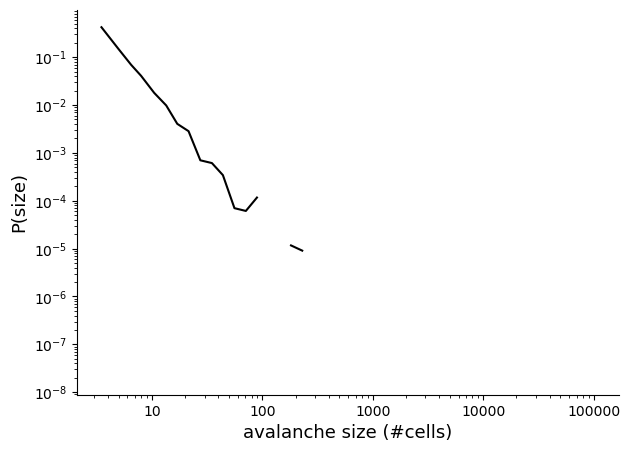

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.3125 0.625


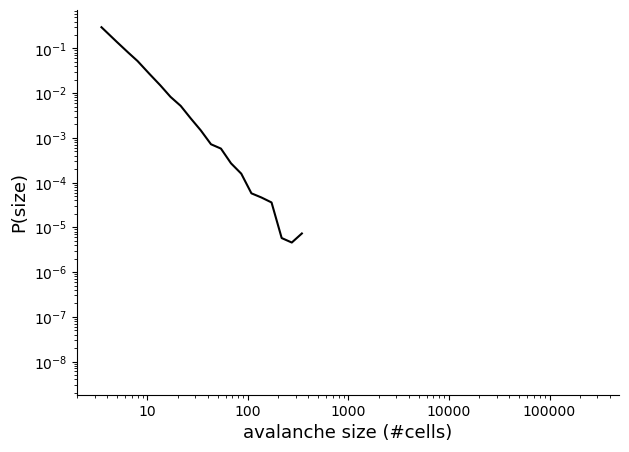

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.3125 0.7


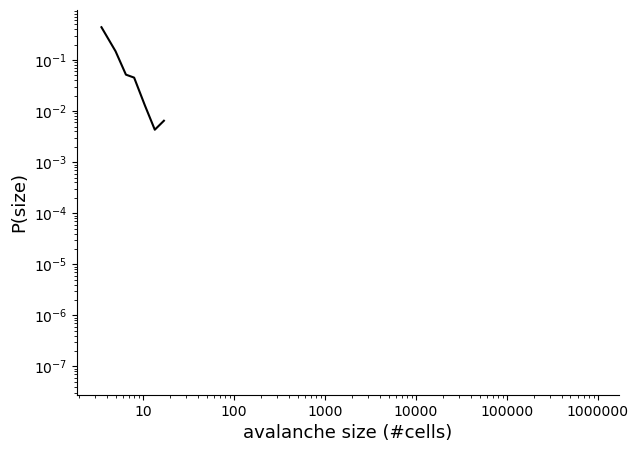

Doing row 0 of 8971
Doing row 897 of 8971
Doing row 1794 of 8971
Doing row 2691 of 8971
Doing row 3588 of 8971
Doing row 4485 of 8971
Doing row 5382 of 8971
Doing row 6279 of 8971
Doing row 7176 of 8971
Doing row 8073 of 8971
Doing row 8970 of 8971
doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.375 0.4


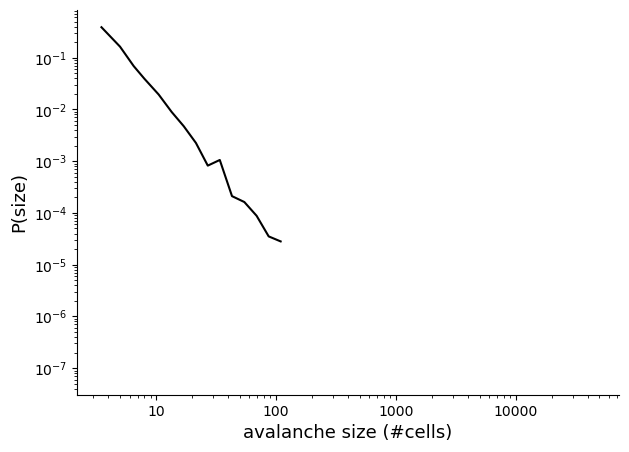

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.375 0.475


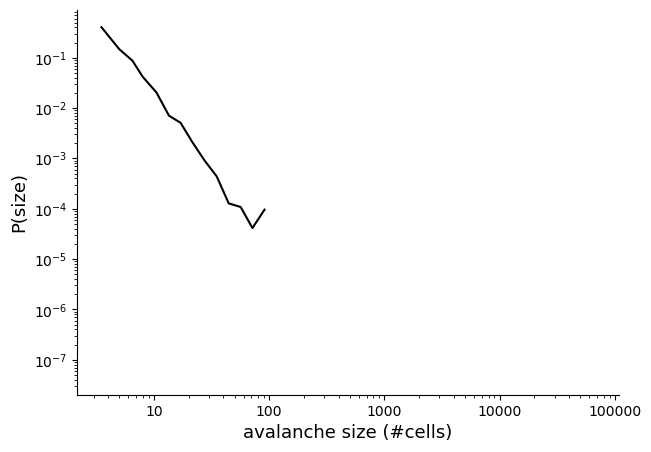

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.375 0.55


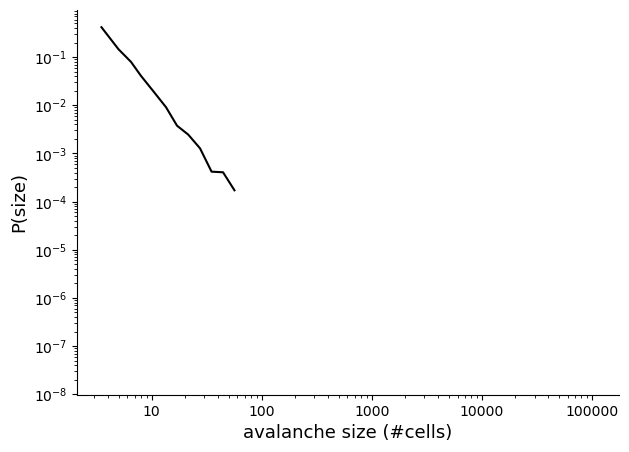

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.375 0.625


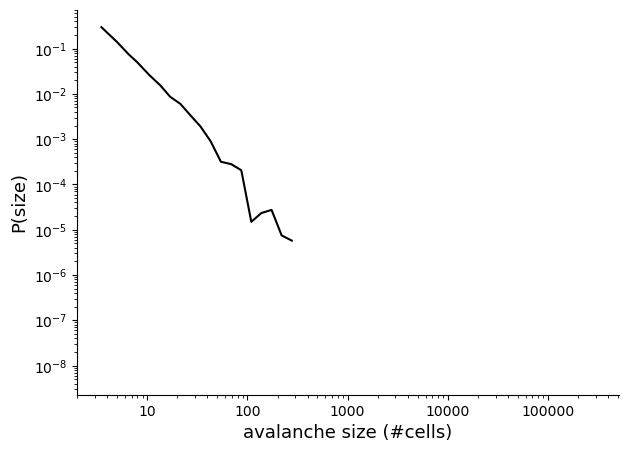

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.375 0.7


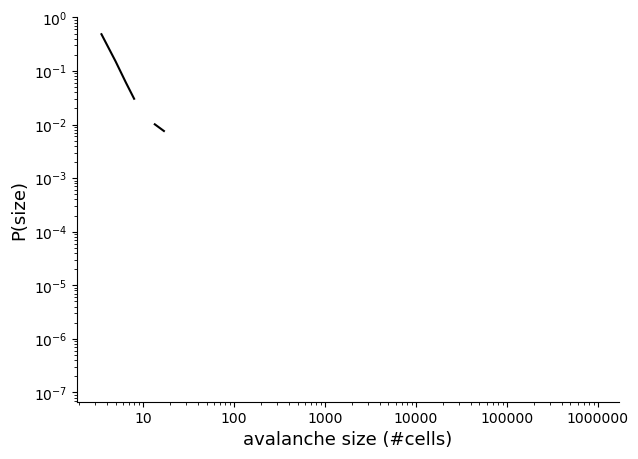

Doing row 0 of 8971
Doing row 897 of 8971
Doing row 1794 of 8971
Doing row 2691 of 8971
Doing row 3588 of 8971
Doing row 4485 of 8971
Doing row 5382 of 8971
Doing row 6279 of 8971
Doing row 7176 of 8971
Doing row 8073 of 8971
Doing row 8970 of 8971
doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.4375 0.4


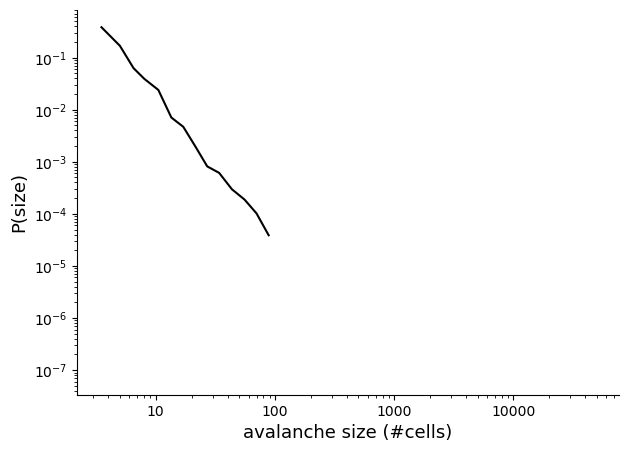

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.4375 0.475


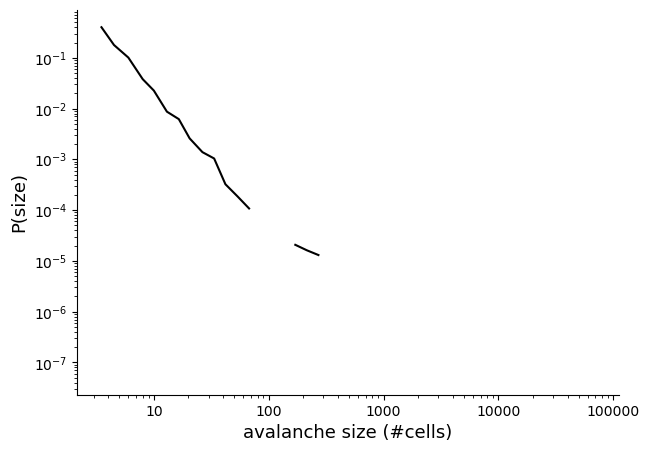

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.4375 0.55


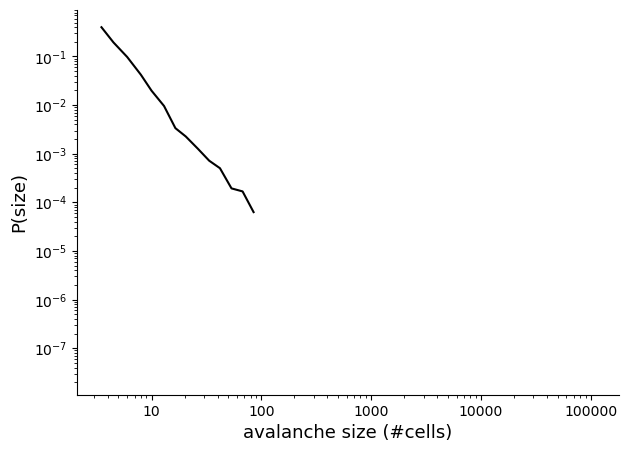

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.4375 0.625


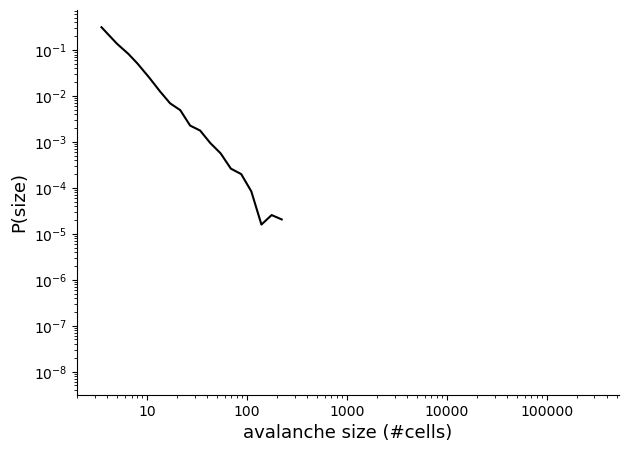

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.4375 0.7


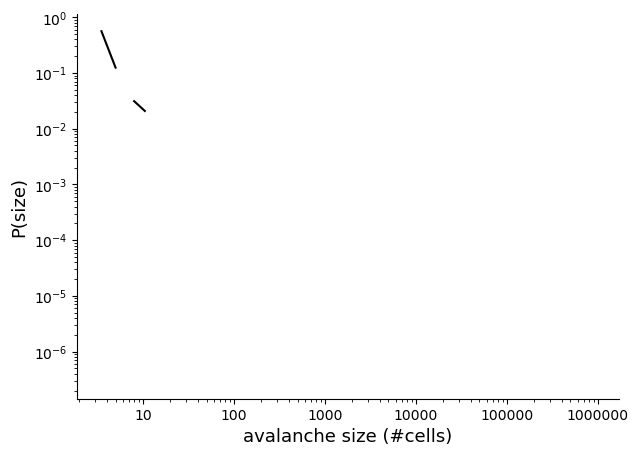

Doing row 0 of 8971
Doing row 897 of 8971
Doing row 1794 of 8971
Doing row 2691 of 8971
Doing row 3588 of 8971
Doing row 4485 of 8971
Doing row 5382 of 8971
Doing row 6279 of 8971
Doing row 7176 of 8971
Doing row 8073 of 8971
Doing row 8970 of 8971
doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.5 0.4


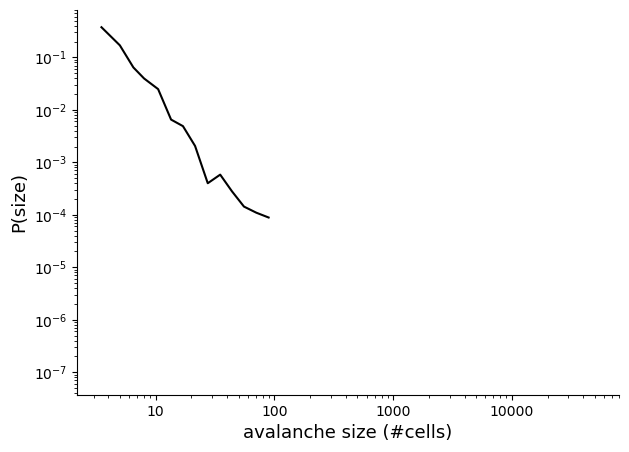

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.5 0.475


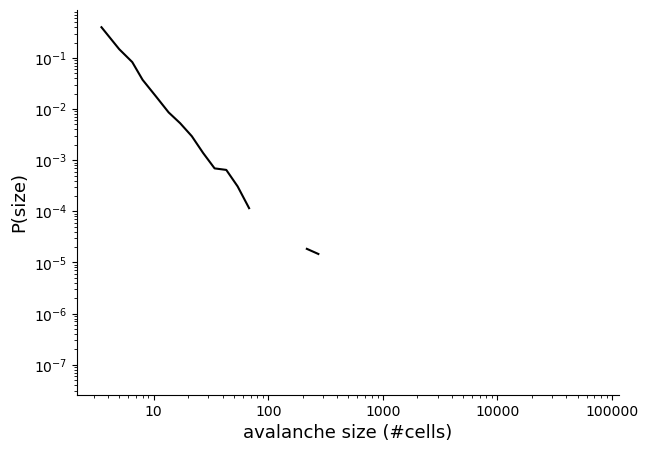

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.5 0.55


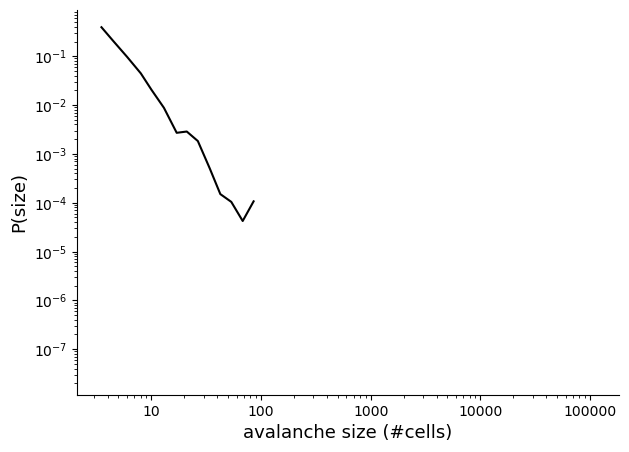

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.5 0.625


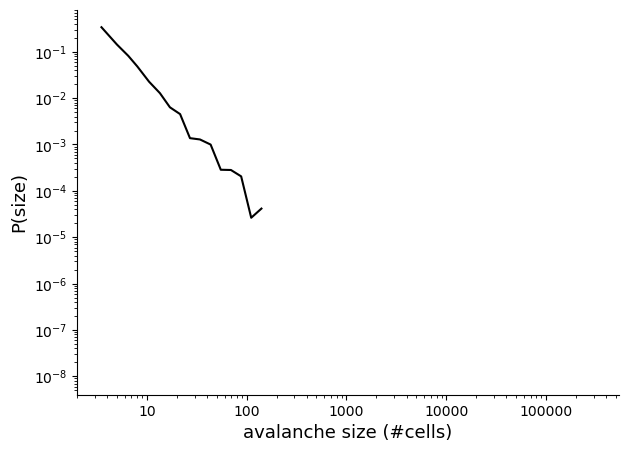

doing time step 0of400for fish 
doing time step 40of400for fish 
doing time step 80of400for fish 
doing time step 120of400for fish 
doing time step 160of400for fish 
doing time step 200of400for fish 
doing time step 240of400for fish 
doing time step 280of400for fish 
doing time step 320of400for fish 
doing time step 360of400for fish 


/Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]


Done 0.5 0.7


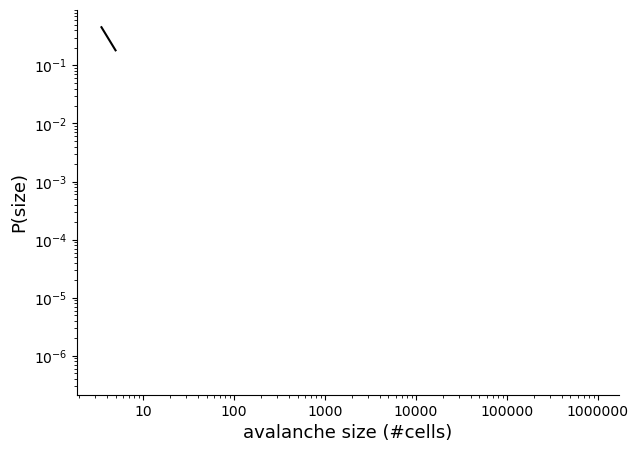

In [45]:
data = p20_list[0]
lamb = 0.5 #calcium decay = 0.5
varB = 0.001 #baseline variance = 0.001
varC = 1 #calcium variance = 1
Cmean = 0.2 #mean calcium = 0.2
frequency = 2.7 #frequency = 2.7
gausfilt = 0.6 #gausfilt = 0.6
mode = 'save'
listlist = [p20_list]
namelist = ['p20_short']
o_list = [2, 4, 5, 7, 8, 9, 10, 11, 12]

for i in range(len(nnb_list)):
    nnb = crfn.neighbour_r(np.load(coords[0]), nnb_list[i], 6000, [1, 1, 1])
    
    for t in range(len(bcl_list)):
        c, sks, B = xfn.bcl_function_parameters(bcl_list[t], Fdrop, experiment, namelist[0], data, lamb, varB, varC, Cmean, frequency, gausfilt, mode)
        avs = crfn.avalanche_r(nnb, sks)
        print('Done ' + str(nnb_list[i]) + ' ' + str(bcl_list[t]))
        import matplotlib
        import powerlaw
        fig, axarr = plt.subplots(figsize = (7,5))

        powerlaw.plot_pdf(avs[0], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'black')
        axarr.set_xscale('log')
        axarr.set_yscale('log')
        axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        #plt.xlim(right = 100000)  
        #plt.ylim(bottom = 0.000005)  
        axarr.set_ylabel('P(size)', size = '13')
        axarr.set_xlabel('avalanche size (#cells)', size = '13')
        axarr.spines['top'].set_visible(False)
        axarr.spines['right'].set_visible(False)
        plt.show()


In [8]:
wdt = 0.57 #spiking probability = 0.57
lamb = 0.5 #calcium decay = 0.5
varB = 0.001 #baseline variance = 0.001
varC = 1 #calcium variance = 1
Cmean = 0.2 #mean calcium = 0.2
frequency = 2.7 #frequency = 2.7
gausfilt = 0.6 #gausfilt = 0.6
mode = 'save'
listlist = [p20_list]
namelist = ['p20_short']
o_list = [2, 4, 5, 7, 8, 9, 10, 11, 12]

for i in range(len(listlist)):
    for t in range(len(listlist[i])):
        name = namelist[i] + '_' + str(o_list[t])
        c, sks, B = xfn.bcl_function_parameters(wdt, Fdrop, experiment, name, listlist[i][t], lamb, varB, varC, Cmean, frequency, gausfilt, mode)
        print('Done ' + name)

Done p20_short_2
Done p20_short_4
Done p20_short_5
Done p20_short_7
Done p20_short_8
Done p20_short_9
Done p20_short_10
Done p20_short_11
Done p20_short_12


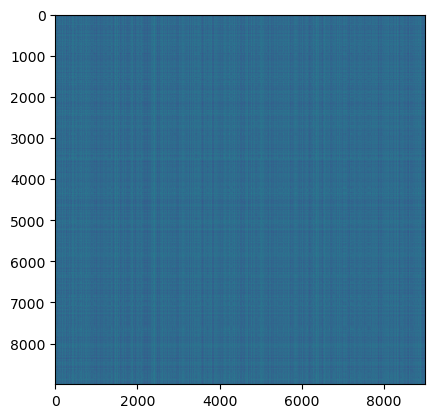

In [3]:
# K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.array(np.append(0.001, np.linspace(0.1, 1, 11))).tolist()
k_vals = np.array(np.append(1/nodes.shape[0], [i/nodes.shape[0] for i in np.linspace(20, 200, 11)])).tolist()
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

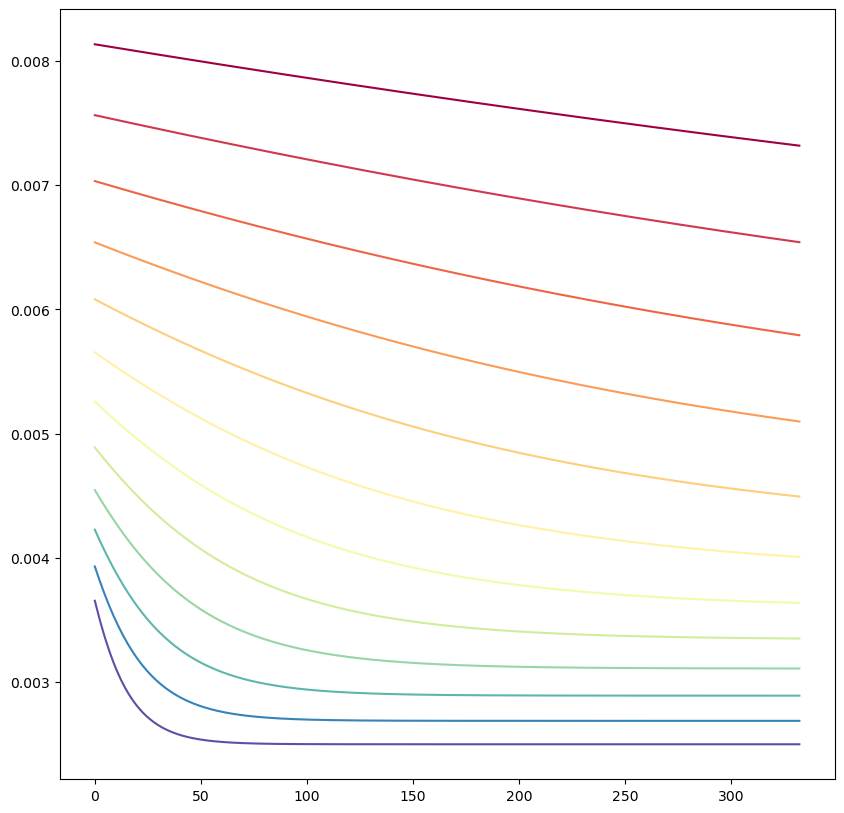

In [4]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


In [5]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))[:1]
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))[:1]

In [6]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

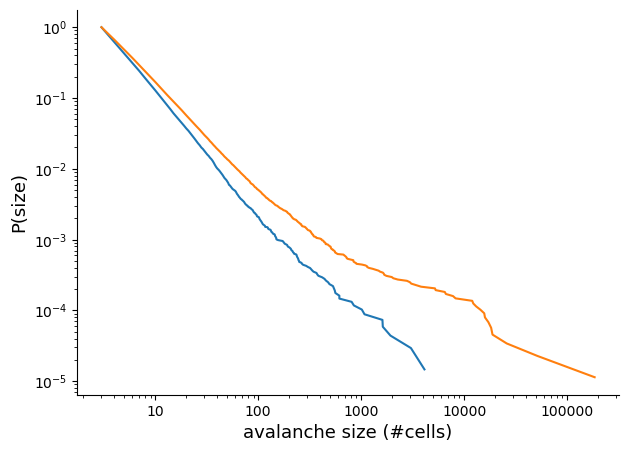

In [7]:
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [8]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

29156

In [62]:
import random
s0 = random.uniform(0, 5)
k0 = random.randint(10, 40)

print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 29156
s0 = 1.0711501945253898
k0 = 40


In [ ]:
slope =  -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:]),np.log10(yaxis[:len(xaxis)-1][1:]))[0]

In [22]:
prac = netfn.ba_netsim(dist).simulate(3, 10, 0,  divisor, soften, cutoff, n_sims, 1).av_size
prac

array([ 3.,  4.,  3.,  4.,  3.,  4.,  3.,  4.,  3., 10., 12.,  3.,  4.,
        3.,  3.,  4.,  3.,  8.,  4.,  3.,  4.,  3.,  3.,  3.,  4.,  8.,
        4.,  3.,  3.,  3.,  3.,  3.,  5.,  3.,  7.,  3.,  4.,  3.,  3.,
        4.,  3.,  4.,  3.,  8.,  3.,  8.,  3.,  3.,  3.,  3.,  5.,  3.,
        3.,  6.,  4.,  4.,  5.,  3.,  3.,  3.,  8.,  3.,  3.,  3.,  3.,
        3.,  3.,  4.,  4.,  4.,  3.,  3.,  3.,  6.,  3.,  3.,  4.,  4.,
        5.,  4.,  4.,  3.,  4.,  3.,  6.,  3.,  3.,  4.,  4.,  4.,  3.,
        3.,  3.,  3.,  4.,  5.,  4.,  3.,  3.,  3.,  3.,  3.,  5.,  4.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  7.,  3.,  9.,  3.,  7.,
        6.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  4.,  3.,  3.,  3., 10.,
        4.,  4.,  4.,  3.,  3.,  7.,  3.,  7.,  4.,  4.,  7.,  3.,  3.,
        4.,  4.,  3.,  7.,  3.,  3.,  3.,  4.,  3.,  3.,  3., 21.,  3.,
        3.,  5.,  7.,  4., 13.,  4.,  3.,  4.,  3., 20.,  5.,  3.,  4.,
        4.,  4.,  3.,  5.,  3.,  3.,  4.,  5.,  4.,  4.,  3.,  4

In [ ]:
slope =  -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:]),np.log10(yaxis[:len(xaxis)-1][1:]))[0]

In [17]:
bln_vec

array([32., 16.,  6., ...,  3.,  6.,  3.])

In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def exp_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0,  divisor, soften, cutoff, n_sims, 1).av_size
    
    
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
ranges = (slice(0, 15, 0.1), slice(2, 10, 1))
result = brute(ks_dist, ranges)

In [20]:
avs = prac
binvec = np.append(empirical,avs)
mini = np.min(binvec)
maxi = np.max(binvec)
bins = 1000
model_hist = axarr.hist(avs, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
model_xaxis = np.log10(model_hist[1])
model_yaxis = np.log10(model_hist[0])

emp_hist = axarr.hist(empirical, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
emp_xaxis = np.log10(emp_hist[1])
emp_yaxis = np.log10(emp_hist[0])
#xstop = np.where(model_yaxis == float("-inf"))[0][0]
#cost = np.linalg.norm(emp_yaxis[:xstop] - model_yaxis[:xstop])


<ipython-input-20-56350228772d>:8: RuntimeWarning: divide by zero encountered in log10
  model_yaxis = np.log10(model_hist[0])


In [ ]:
slope =  -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:]),np.log10(yaxis[:len(xaxis)-1][1:]))[0]

<ipython-input-26-08818574b7f0>:7: RuntimeWarning: divide by zero encountered in log10
  yaxis = np.log10(hist[0]/np.sum(hist[0]))


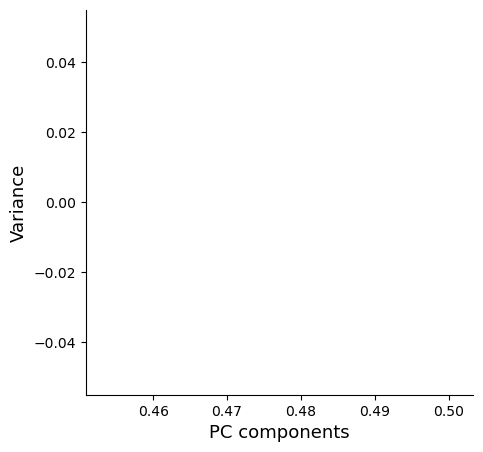

In [26]:
fig, axarr = plt.subplots(figsize = (5,5))

avdistcut = prac
binned=np.linspace(mini,maxi, 67)
hist = np.histogram(avdistcut, bins = binned)
xaxis = np.log10(hist[1][:-1])
yaxis = np.log10(hist[0]/np.sum(hist[0]))
axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)


axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axarr.set_ylabel('Variance', size = '13')
axarr.set_xlabel('PC components', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


In [ ]:
avs = prac
binvec = np.append(empirical,avs)
mini = np.min(binvec)
maxi = np.max(binvec)
bins = 1000000
model_hist = axarr.hist(avs, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
model_xaxis = np.log10(model_hist[1])
model_yaxis = np.log10(model_hist[0])
m,c = np.polyfit(np.log10(xaxis[:len(xaxis)-1][1:]), np.log10(yaxis[:len(xaxis)-1][1:]), 1)
y_fit = np.exp(m*(np.log10(xaxis[:len(xaxis)-1])) + c) # calculate the fitted values of y 
plt.plot(xaxis[:len(xaxis)-1], y_fit[:len(xaxis)-1])


In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0,  divisor, soften, cutoff, n_sims, 1).av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
ranges = (slice(0, 15, 0.1), slice(2, 10, 1))
result = brute(ks_dist, ranges)

In [87]:
result

array([ 3.33932874, 21.71079496])

In [11]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
np.save('optimise_brute_ksdistlow_ba_blnf1_params.npy',   paramlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_cost.npy',    costlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 1601  true min = 1510
min cost = 0.00806875683292052
min params = [8.85222392 5.06457948]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

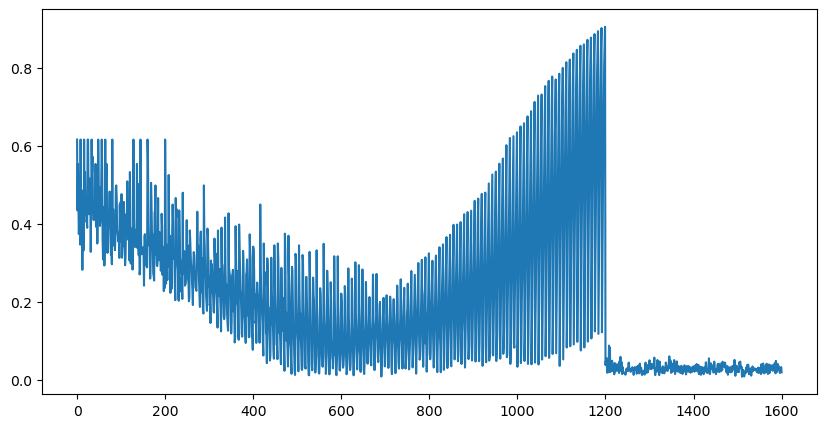

In [13]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

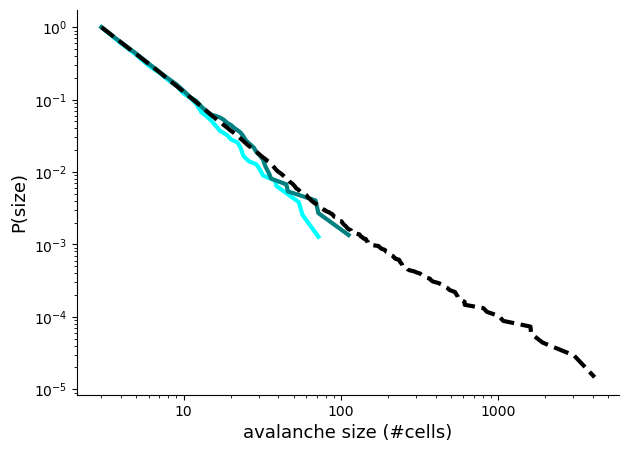

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

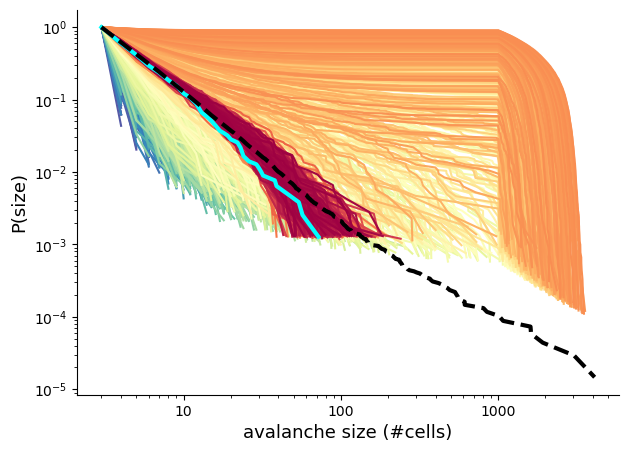

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

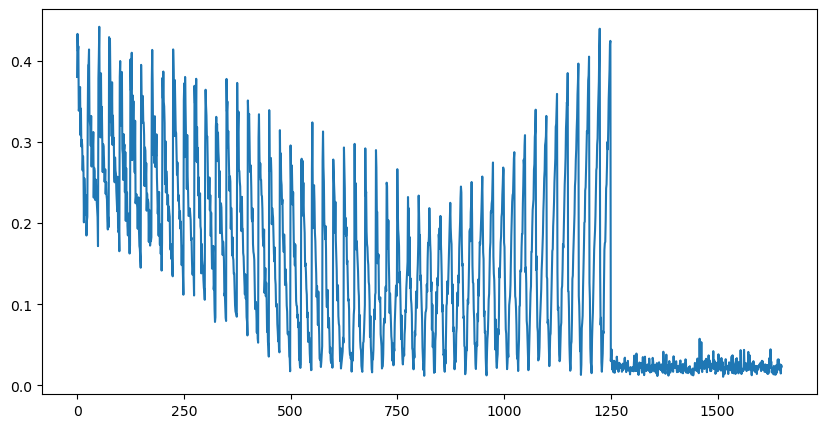

In [89]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

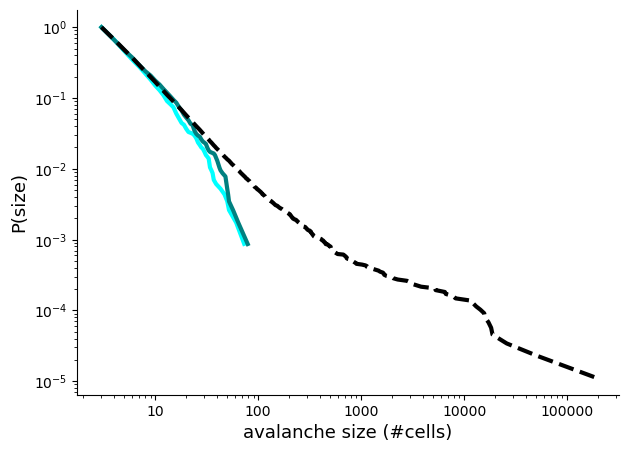

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

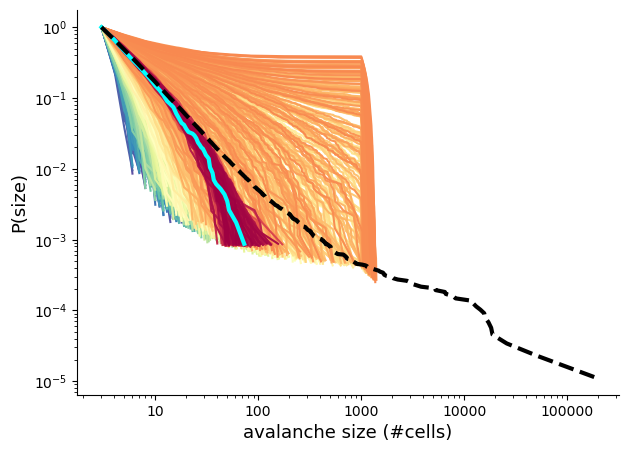

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba_*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba_*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba_*params.npy'))
avlist, costlist, paramlist

(['optimise_brute_ksdist_ba_blnf1_avs.npy',
  'optimise_brute_ksdist_ba_p20f1_avs.npy'],
 ['optimise_brute_ksdist_ba_blnf1_cost.npy',
  'optimise_brute_ksdist_ba_p20f1_cost.npy'],
 ['optimise_brute_ksdist_ba_blnf1_params.npy',
  'optimise_brute_ksdist_ba_p20f1_params.npy'])

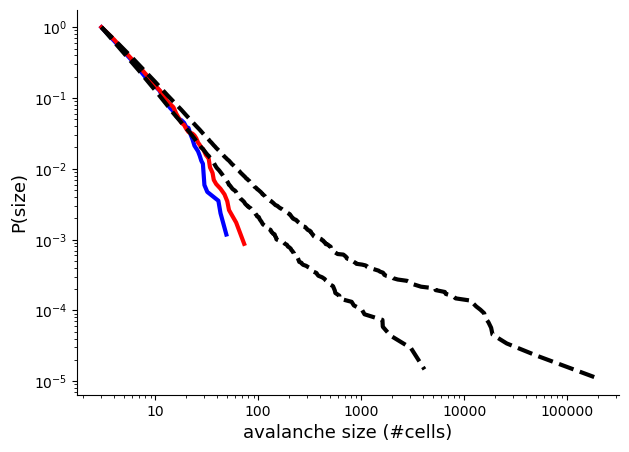

baseline = [ 4.19261721 14.67675784]
ptz = [ 3.33932874 21.71079496]


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

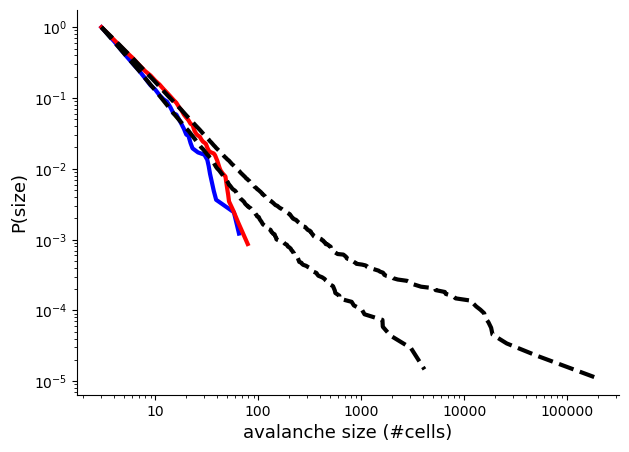

baseline = [ 4.19261721 14.67675784]
ptz = [ 3.33932874 21.71079496]


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw


bln_curr = np.load(avlist[0], allow_pickle=True)[np.where(np.load(costlist[0]) == np.min(np.load(costlist[0])))[0][0]]
ptz_curr = np.load(avlist[1], allow_pickle=True)[np.where(np.load(costlist[1]) == np.min(np.load(costlist[1])))[0][0]]

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = bln_curr
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = ptz_curr
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[np.where(np.load(costlist[0]) == np.min(np.load(costlist[0])))[0][0]]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[np.where(np.load(costlist[1]) == np.min(np.load(costlist[1])))[0][0]]))